## This approach will filter out unspecific diseases and group synonymous classes
### A EfficientNetb0 will be trained on those 

'alternaria leaf spot',
'bacterial blight',
 'bacterial spot',
 'bacterial_wilt',
 'black_measles',
 'black_rot',
 'blast',
 'brown_spot' (combined with septoria)
 'brown_streak_disease',
 'citrus_greening',
 'common rust', 
 'early_blight',
 'gray leaf spot',
 'healthy',
 'isariopsis_leaf_spot',
 'late blight' (combined with phytophora),
 'leaf_curl',
 'leaf_mold',
 'northern_leaf_blight',
 'powdery_mildew',
 'red_rot',
 'spider_mites',
 'target spot', 
 'tungro'
 'mosaic_disease' (combines with mosaic_virus),


leaf_blight also can be exclude (check)
leaf_curl is a condition not disease. (check)
leaf scorch (check)
pests (check)
nematode (check)
virus (check)
phytophthora (Phytophthora infestans is a devastating plant pathogen that causes late blight disease in potatoes.) should be merged with 
We should exclude yellow_leaf because it is condition not disease. (bearbeitet) (check)
mosaic disease not symtom (check)
gray spot
rust: not specific enough
scab: same
green mottle, too bad data coverage








In [83]:
import os
#Import nessesary packages, libraries and global variables

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from  PIL import Image
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import split_dataset
import tensorflow as tf
from tensorflow import keras
from keras import layers

import sys
sys.path.append('../modeling')

RSEED = 42
dataset_path = '../data/filtered_diseases/train_filtered/'

import tensorflow.keras.backend as K

In [84]:


data_path = '../data/filtered_diseases/train_filtered'
file_count = len(os.listdir(data_path))
file_count

26

In [41]:


def get_differing_files(dir1, dir2):
    return set(os.listdir(dir1)) ^ set(os.listdir(dir2))

dir1 = '../data/filtered_diseases/train_filtered'
dir2 = '../data/filtered_diseases/test_filtered'

differing_files = get_differing_files(dir1, dir2)
print("Differing files:", differing_files)

Differing files: set()


In [ ]:
'''import shutil

source_dir = '../data/filtered_diseases/train_filtered/brown_spot/septoria_leaf_spot/'
destination_dir = '../data/filtered_diseases/train_filtered/brown_spot'

# Move the contents of the source directory to the destination directory
shutil.move(source_dir, destination_dir)'''

In [5]:
'''# Iterate over each item in the source directory
for item in os.listdir(source_dir):
    # Get the full path of the item
    item_path = os.path.join(source_dir, item)
    # Move the item to the destination directory
    shutil.move(item_path, destination_dir)'''

### short EDA

In [42]:
file_types = {}

def count_file_types(folder): 
    for root, dirs, files in os.walk(folder): 
        for file in files: # Get the file extension 
            file_extension = os.path.splitext(file)[1][1:].lower()
            file_types[file_extension] = file_types.get(file_extension, 0) + 1

folder_path = '../data/filtered_diseases/train_filtered/'
count_file_types(folder_path)

for file_type, count in file_types.items(): print(f"{file_type}: {count}")

: 2
jpg: 70884


In [85]:
def load_preprocess_split_train_val(data_path):
    ''' 
    Function needs filefath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image = tf.keras.utils.image_dataset_from_directory(
        data_path, 
        validation_split = 0.2,
        subset = "both", 
        seed = RSEED,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical'
    )
    return image 

In [86]:
train_ds, val_ds = load_preprocess_split_train_val(dataset_path)

Found 68993 files belonging to 25 classes.
Using 55195 files for training.
Using 13798 files for validation.


In [87]:

K.clear_session()

In [88]:
#define model

model = keras.applications.EfficientNetB0(
    include_top=False
)

In [89]:
#get overview of the model architecture

model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [90]:

IMG_SIZE = 224
BATCH_SIZE = 32

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) # Define the input layer with the shape of input images
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet") # Load the EfficientNetB0 model pretrained on ImageNet without the top classification layer
                                                                                        # Use the input layer defined above

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output) # Apply global average pooling to the output of the base layers
    x = layers.BatchNormalization()(x) # Apply batch normalization to normalize the activations of the previous layer


    top_dropout_rate = 0.2 # Define the dropout rate
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x) # Apply dropout regularization to the previous layer
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x) # Add a dense layer for classification with softmax activation

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet") # Construct the final model with the specified input and output layers
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-2) # Define the optimizer with a learning rate of 0.01 using the Adam optimizer
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return model

In [91]:
model = build_model(num_classes=25)

In [92]:
#next we want to unfreeze 10 layers and retrain 

import tensorflow as tf

def unfreeze_model_and_clone(model):
    # Clone the original model
    unfrozen_model = tf.keras.models.clone_model(model)
    unfrozen_model.set_weights(model.get_weights())  # Copy weights

    # Unfreeze the top 10 layers while leaving BatchNorm layers frozen
    for layer in unfrozen_model.layers[-10:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
    unfrozen_model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return unfrozen_model

In [93]:
# Create a new model with unfrozen layers
patho_model_10 = unfreeze_model_and_clone(model)

epochs = 10
hist = patho_model_10.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
1725/1725 [==============================] - 484s 277ms/step - loss: 2.0382 - accuracy: 0.4811 - val_loss: 1.2035 - val_accuracy: 0.6776
Epoch 2/10
1725/1725 [==============================] - 478s 277ms/step - loss: 1.1538 - accuracy: 0.6836 - val_loss: 0.8848 - val_accuracy: 0.7476
Epoch 3/10
1725/1725 [==============================] - 503s 291ms/step - loss: 0.9171 - accuracy: 0.7387 - val_loss: 0.7419 - val_accuracy: 0.7813
Epoch 4/10
1725/1725 [==============================] - 518s 300ms/step - loss: 0.7903 - accuracy: 0.7667 - val_loss: 0.6552 - val_accuracy: 0.8013
Epoch 5/10
1725/1725 [==============================] - 549s 318ms/step - loss: 0.7067 - accuracy: 0.7894 - val_loss: 0.6000 - val_accuracy: 0.8156
Epoch 6/10
1725/1725 [==============================] - 2438s 1s/step - loss: 0.6438 - accuracy: 0.8047 - val_loss: 0.5585 - val_accuracy: 0.8264
Epoch 7/10
1725/1725 [==============================] - 471s 273ms/step - loss: 0.6031 - accuracy: 0.8151 - val_lo

In [94]:
patho_model_10.save('patho_model_10.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [95]:
import matplotlib.pyplot as plt

def plot_training_metrics(history):
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

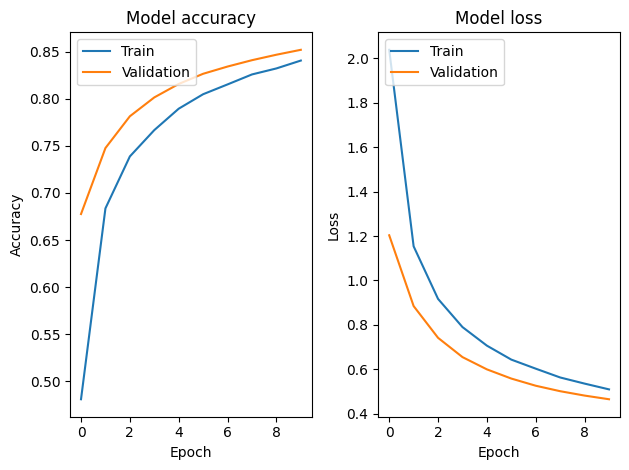

In [96]:
plot_training_metrics(hist)

In [97]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def load_test(data_path):
    ''' 
    Function needs filepath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image_dataset = tf.keras.utils.image_dataset_from_directory(
        data_path,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical',
        shuffle = False
    )
    return image_dataset 


In [98]:
dataset_test_path = '../data/filtered_diseases/test_filtered/'

test_ds = load_test(dataset_test_path)

Found 17288 files belonging to 25 classes.


In [100]:

# Step 1: Get the true labels from the test dataset
y_true = []
for filepath in test_ds.file_paths:
    label = os.path.basename(os.path.dirname(filepath))
    y_true.append(label)

# Extract unique class labels from your training data
classes = sorted(set(y_true))

# Step 2: Convert true labels to indices using the same mapping used during training
class_to_index = {cls: i for i, cls in enumerate(classes)}
y_true_indices = np.array([class_to_index[label] for label in y_true])

# Step 3: Use your model to make predictions on the test dataset
y_pred_probabilities = patho_model_10.predict(test_ds)

# Step 4: Convert the predicted class probabilities to class labels
y_pred_indices = np.argmax(y_pred_probabilities, axis=1)
y_pred = [classes[i] for i in y_pred_indices]

# Step 5: Generate the classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)


541/541 [==============================] - 116s 215ms/step
Classification Report:
                      precision    recall  f1-score   support

alternaria_leaf_spot       0.98      0.69      0.81       128
    bacterial_blight       0.65      0.44      0.53       584
      bacterial_spot       0.91      0.96      0.93      1157
      bacterial_wilt       0.83      0.53      0.65       113
       black_measles       0.86      0.77      0.81       449
           black_rot       0.96      0.96      0.96       384
               blast       0.81      0.67      0.74       303
          brown_spot       0.85      0.78      0.81       698
brown_streak_disease       0.51      0.37      0.43       451
     citrus_greening       1.00      1.00      1.00      1183
         common_rust       0.90      0.87      0.88       224
        early_blight       0.89      0.82      0.85       656
      gray_leaf_spot       0.73      0.49      0.59        98
             healthy       0.85      0.86      0.

In [60]:
y_pred_probabilities

array([[2.8365588e-01, 1.8602439e-03, 1.1910431e-03, ..., 2.6136015e-03,
        5.3375289e-03, 4.9232761e-03],
       [2.8365588e-01, 1.8602439e-03, 1.1910431e-03, ..., 2.6136015e-03,
        5.3375289e-03, 4.9232761e-03],
       [4.7323713e-01, 1.8639660e-03, 1.3165810e-03, ..., 3.7086378e-03,
        2.4159062e-03, 4.4597234e-03],
       ...,
       [1.5716272e-04, 3.8082349e-01, 4.3574686e-04, ..., 2.1776333e-03,
        7.2304369e-04, 1.3502304e-01],
       [6.0936005e-04, 2.4794206e-01, 2.6557967e-04, ..., 1.4988283e-03,
        5.9332483e-04, 3.6977628e-01],
       [7.8269775e-04, 8.3355131e-03, 2.6214952e-05, ..., 1.6773554e-05,
        3.3238807e-06, 9.7937268e-01]], dtype=float32)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step


  1%|          | 10/1000 [00:03<06:25,  2.57it/s]

1/1 [==============================] - 0s 206ms/step


  2%|▏         | 20/1000 [00:04<02:56,  5.56it/s]

1/1 [==============================] - 0s 292ms/step


  3%|▎         | 30/1000 [00:04<01:49,  8.82it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 40/1000 [00:04<01:11, 13.51it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 50/1000 [00:04<00:49, 19.04it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 60/1000 [00:04<00:36, 25.64it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 70/1000 [00:05<00:28, 32.71it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 80/1000 [00:05<00:22, 40.36it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 90/1000 [00:05<00:19, 46.85it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 100/1000 [00:05<00:16, 53.11it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 110/1000 [00:05<00:15, 58.73it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 120/1000 [00:05<00:13, 63.84it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 130/1000 [00:05<00:13, 66.74it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 140/1000 [00:06<00:12, 70.18it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▌        | 150/1000 [00:06<00:13, 62.20it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 160/1000 [00:06<00:12, 66.18it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 170/1000 [00:06<00:12, 69.04it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 180/1000 [00:06<00:11, 71.62it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 190/1000 [00:06<00:11, 73.21it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 200/1000 [00:06<00:10, 75.40it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 210/1000 [00:06<00:10, 77.32it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 220/1000 [00:07<00:10, 77.02it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 230/1000 [00:07<00:10, 76.92it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 240/1000 [00:07<00:09, 77.25it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 250/1000 [00:07<00:09, 78.68it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 260/1000 [00:07<00:09, 79.76it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 270/1000 [00:07<00:09, 80.23it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 280/1000 [00:07<00:09, 79.92it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 290/1000 [00:07<00:09, 78.31it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 300/1000 [00:08<00:08, 78.65it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 310/1000 [00:08<00:08, 78.84it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 320/1000 [00:08<00:08, 79.77it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 330/1000 [00:08<00:08, 80.48it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 340/1000 [00:08<00:08, 79.76it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 350/1000 [00:08<00:08, 77.96it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 360/1000 [00:08<00:08, 75.82it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 370/1000 [00:09<00:08, 77.94it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 380/1000 [00:09<00:07, 79.19it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 390/1000 [00:09<00:07, 79.50it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 400/1000 [00:09<00:07, 80.66it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 410/1000 [00:09<00:07, 81.44it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 420/1000 [00:09<00:07, 81.47it/s]

1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 430/1000 [00:09<00:07, 76.87it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 440/1000 [00:09<00:07, 78.83it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 450/1000 [00:10<00:06, 79.88it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 460/1000 [00:10<00:07, 76.05it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 470/1000 [00:10<00:06, 78.15it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 480/1000 [00:10<00:06, 79.34it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 490/1000 [00:10<00:06, 80.22it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 500/1000 [00:10<00:06, 80.73it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 510/1000 [00:10<00:06, 81.02it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 520/1000 [00:10<00:05, 80.07it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 530/1000 [00:11<00:06, 72.03it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 540/1000 [00:11<00:06, 75.21it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 550/1000 [00:11<00:05, 77.38it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 560/1000 [00:11<00:05, 78.69it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 570/1000 [00:11<00:05, 79.39it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 580/1000 [00:11<00:05, 78.12it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 590/1000 [00:11<00:05, 79.07it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 600/1000 [00:11<00:04, 80.39it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 610/1000 [00:12<00:04, 81.34it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 620/1000 [00:12<00:04, 81.72it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 630/1000 [00:12<00:04, 82.00it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 640/1000 [00:12<00:04, 82.46it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 650/1000 [00:12<00:04, 81.52it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 660/1000 [00:12<00:04, 80.49it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 670/1000 [00:12<00:04, 80.21it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 680/1000 [00:12<00:03, 80.80it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 690/1000 [00:13<00:03, 81.21it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 700/1000 [00:13<00:03, 80.21it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 710/1000 [00:13<00:03, 81.24it/s]

1/1 [==============================] - 0s 67ms/step


 72%|███████▏  | 720/1000 [00:13<00:04, 64.78it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 730/1000 [00:13<00:03, 68.94it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 740/1000 [00:13<00:03, 72.08it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 750/1000 [00:13<00:03, 73.04it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 760/1000 [00:14<00:03, 75.38it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 770/1000 [00:14<00:03, 74.84it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 780/1000 [00:14<00:02, 75.11it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 790/1000 [00:14<00:02, 75.52it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 800/1000 [00:14<00:02, 76.66it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 810/1000 [00:14<00:02, 72.75it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 820/1000 [00:14<00:02, 74.49it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 830/1000 [00:14<00:02, 75.67it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 840/1000 [00:15<00:02, 75.58it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 850/1000 [00:15<00:01, 75.94it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 860/1000 [00:15<00:01, 75.87it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 870/1000 [00:15<00:01, 77.15it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 880/1000 [00:15<00:01, 76.79it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 890/1000 [00:15<00:01, 77.04it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 900/1000 [00:15<00:01, 77.23it/s]

1/1 [==============================] - 0s 70ms/step


 91%|█████████ | 910/1000 [00:16<00:01, 67.27it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 920/1000 [00:16<00:01, 68.02it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 930/1000 [00:16<00:01, 69.76it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 940/1000 [00:16<00:00, 69.65it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 950/1000 [00:16<00:00, 72.95it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 960/1000 [00:16<00:00, 74.27it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 970/1000 [00:16<00:00, 75.19it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 980/1000 [00:16<00:00, 77.17it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 990/1000 [00:17<00:00, 77.40it/s]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 1000/1000 [00:17<00:00, 58.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


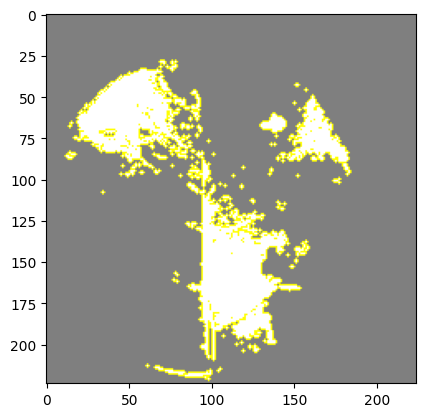

In [101]:
import lime
import tensorflow as tf
from tensorflow import keras
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array
def display_original_and_explanation(image_path, model, num_features=5, num_samples=1000):
    # Load and preprocess the original image
    original_image = load_and_preprocess_image(image_path)
    # Create a LIME explainer
    explainer = lime_image.LimeImageExplainer()
    # Generate explanation for the model's prediction
    explanation = explainer.explain_instance(original_image[0].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=num_samples)
    # Get the visualized explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=num_features, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

    

# Path to image file
image_path = '../data/filtered_diseases/test_filtered/alternaria_leaf_spot/000424.out.jpg'
display_original_and_explanation(image_path, patho_model_10)



In [102]:

# Path to image file
image_path = '../data/test/alternaria_leaf_spot/000424.jpg'
display_original_and_explanation(image_path, patho_model_6)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  1%|          | 10/1000 [00:02<04:02,  4.08it/s]

1/1 [==============================] - 0s 204ms/step


  2%|▏         | 20/1000 [00:02<01:58,  8.27it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 30/1000 [00:02<01:09, 13.95it/s]

1/1 [==============================] - 0s 72ms/step


  4%|▍         | 40/1000 [00:03<00:47, 20.11it/s]

1/1 [==============================] - 0s 105ms/step


  5%|▌         | 50/1000 [00:03<00:37, 25.47it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 60/1000 [00:03<00:28, 33.03it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 70/1000 [00:03<00:22, 40.48it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 80/1000 [00:03<00:19, 46.31it/s]

1/1 [==============================] - 0s 71ms/step


  9%|▉         | 90/1000 [00:03<00:17, 50.77it/s]

1/1 [==============================] - 0s 61ms/step


 10%|█         | 100/1000 [00:04<00:17, 52.73it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 110/1000 [00:04<00:16, 54.91it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 120/1000 [00:04<00:14, 60.54it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 130/1000 [00:04<00:13, 64.55it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 140/1000 [00:04<00:12, 69.03it/s]

1/1 [==============================] - 0s 50ms/step


 15%|█▌        | 150/1000 [00:04<00:12, 70.82it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 160/1000 [00:04<00:11, 72.33it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 170/1000 [00:04<00:11, 73.04it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 180/1000 [00:05<00:11, 73.02it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 190/1000 [00:05<00:10, 73.85it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 200/1000 [00:05<00:10, 74.74it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 210/1000 [00:05<00:10, 75.70it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 220/1000 [00:05<00:10, 75.49it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 230/1000 [00:05<00:10, 75.77it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 240/1000 [00:05<00:09, 76.73it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 250/1000 [00:06<00:09, 77.76it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 260/1000 [00:06<00:09, 78.16it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 270/1000 [00:06<00:09, 78.39it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 280/1000 [00:06<00:09, 78.94it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 290/1000 [00:06<00:08, 79.13it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 300/1000 [00:06<00:08, 79.71it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 310/1000 [00:06<00:08, 79.76it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 320/1000 [00:06<00:08, 79.40it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 330/1000 [00:07<00:08, 76.50it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 340/1000 [00:07<00:09, 72.45it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 350/1000 [00:07<00:08, 74.44it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 360/1000 [00:07<00:08, 74.39it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 370/1000 [00:07<00:08, 75.09it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 380/1000 [00:07<00:08, 76.38it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 390/1000 [00:07<00:08, 75.35it/s]

1/1 [==============================] - 0s 61ms/step


 40%|████      | 400/1000 [00:08<00:09, 65.58it/s]

1/1 [==============================] - 0s 188ms/step


 41%|████      | 410/1000 [00:08<00:10, 56.61it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 420/1000 [00:08<00:09, 60.89it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 430/1000 [00:08<00:08, 65.70it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 440/1000 [00:08<00:08, 67.96it/s]

1/1 [==============================] - 0s 64ms/step


 45%|████▌     | 450/1000 [00:08<00:09, 56.04it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 460/1000 [00:09<00:09, 57.59it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 470/1000 [00:09<00:08, 62.86it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 480/1000 [00:09<00:07, 66.17it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 490/1000 [00:09<00:07, 68.60it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 500/1000 [00:09<00:07, 70.72it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 510/1000 [00:09<00:06, 71.94it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 520/1000 [00:09<00:07, 67.91it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 530/1000 [00:10<00:06, 71.42it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 540/1000 [00:10<00:06, 70.45it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 550/1000 [00:10<00:06, 72.91it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 560/1000 [00:10<00:05, 74.84it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 570/1000 [00:10<00:05, 72.63it/s]

1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 580/1000 [00:10<00:06, 66.83it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 590/1000 [00:10<00:06, 66.05it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 600/1000 [00:11<00:05, 68.39it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 610/1000 [00:11<00:05, 71.55it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 620/1000 [00:11<00:05, 72.68it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 630/1000 [00:11<00:04, 74.49it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 640/1000 [00:11<00:04, 75.40it/s]

1/1 [==============================] - 0s 63ms/step


 65%|██████▌   | 650/1000 [00:11<00:05, 65.03it/s]

1/1 [==============================] - 0s 315ms/step


 66%|██████▌   | 660/1000 [00:12<00:07, 43.60it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 670/1000 [00:12<00:06, 49.21it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 680/1000 [00:12<00:05, 54.42it/s]

1/1 [==============================] - 0s 320ms/step


 69%|██████▉   | 690/1000 [00:12<00:07, 41.84it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 700/1000 [00:12<00:06, 48.08it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 710/1000 [00:13<00:05, 54.17it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 720/1000 [00:13<00:04, 59.54it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 730/1000 [00:13<00:04, 63.74it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 740/1000 [00:13<00:03, 65.52it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▌  | 750/1000 [00:13<00:03, 64.03it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 760/1000 [00:13<00:03, 66.14it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 770/1000 [00:13<00:03, 70.46it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 780/1000 [00:14<00:03, 71.43it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 790/1000 [00:14<00:02, 73.95it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 800/1000 [00:14<00:02, 74.80it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 810/1000 [00:14<00:02, 77.56it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 820/1000 [00:14<00:02, 79.38it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 830/1000 [00:14<00:02, 68.66it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 840/1000 [00:14<00:02, 72.11it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 850/1000 [00:14<00:02, 74.45it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 860/1000 [00:15<00:01, 76.87it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 870/1000 [00:15<00:01, 78.54it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 880/1000 [00:15<00:01, 79.08it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 890/1000 [00:15<00:01, 79.75it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 900/1000 [00:15<00:01, 79.74it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 910/1000 [00:15<00:01, 79.33it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 920/1000 [00:15<00:00, 80.11it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 930/1000 [00:15<00:00, 79.60it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 940/1000 [00:16<00:00, 79.86it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 950/1000 [00:16<00:00, 80.23it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 960/1000 [00:16<00:00, 80.57it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 979/1000 [00:16<00:00, 59.23it/s]


KeyboardInterrupt: 

In [103]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
# set IMAGE and MODEL global variables


1/1 [==============================] - 0s 366ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 86ms/step


  1%|          | 10/1000 [00:00<00:27, 35.95it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 20/1000 [00:00<00:18, 52.75it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 30/1000 [00:00<00:15, 62.00it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 40/1000 [00:00<00:14, 67.91it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 50/1000 [00:00<00:13, 72.08it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 60/1000 [00:00<00:12, 72.91it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 70/1000 [00:01<00:12, 74.40it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 80/1000 [00:01<00:12, 73.93it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 90/1000 [00:01<00:12, 75.43it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 100/1000 [00:01<00:12, 73.80it/s]

1/1 [==============================] - 0s 73ms/step


 11%|█         | 110/1000 [00:01<00:13, 66.50it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 120/1000 [00:01<00:12, 68.97it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 130/1000 [00:01<00:12, 71.86it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 140/1000 [00:02<00:11, 75.38it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 150/1000 [00:02<00:10, 77.65it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 160/1000 [00:02<00:10, 80.09it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 170/1000 [00:02<00:10, 80.84it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 180/1000 [00:02<00:10, 80.57it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 190/1000 [00:02<00:09, 81.19it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 200/1000 [00:02<00:09, 82.03it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 210/1000 [00:02<00:09, 81.51it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 220/1000 [00:02<00:09, 82.22it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 230/1000 [00:03<00:09, 79.99it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 240/1000 [00:03<00:09, 80.78it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 250/1000 [00:03<00:09, 81.30it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 260/1000 [00:03<00:09, 81.13it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 270/1000 [00:03<00:08, 81.73it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 280/1000 [00:03<00:08, 81.81it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 290/1000 [00:03<00:08, 82.56it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 300/1000 [00:03<00:08, 82.73it/s]

1/1 [==============================] - 0s 59ms/step


 31%|███       | 310/1000 [00:04<00:09, 74.13it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 320/1000 [00:04<00:08, 77.57it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 330/1000 [00:04<00:08, 79.94it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 340/1000 [00:04<00:08, 80.24it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 350/1000 [00:04<00:08, 80.61it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 360/1000 [00:04<00:07, 82.19it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 370/1000 [00:04<00:07, 83.36it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 380/1000 [00:04<00:07, 83.83it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 390/1000 [00:05<00:07, 84.33it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 400/1000 [00:05<00:07, 84.56it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 410/1000 [00:05<00:06, 84.85it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 420/1000 [00:05<00:06, 85.30it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 430/1000 [00:05<00:06, 84.73it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 440/1000 [00:05<00:06, 84.72it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 450/1000 [00:05<00:06, 85.06it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 460/1000 [00:05<00:06, 85.12it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 470/1000 [00:06<00:06, 84.15it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 480/1000 [00:06<00:06, 82.25it/s]

1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 490/1000 [00:06<00:06, 76.07it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 500/1000 [00:06<00:06, 79.00it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 510/1000 [00:06<00:06, 80.90it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 520/1000 [00:06<00:05, 82.48it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 530/1000 [00:06<00:05, 83.42it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 540/1000 [00:06<00:05, 84.10it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 550/1000 [00:06<00:05, 84.23it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 560/1000 [00:07<00:05, 85.08it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 570/1000 [00:07<00:05, 85.22it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 580/1000 [00:07<00:04, 84.35it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 590/1000 [00:07<00:04, 84.86it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 600/1000 [00:07<00:04, 85.48it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 610/1000 [00:07<00:04, 85.95it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 620/1000 [00:07<00:04, 86.33it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 630/1000 [00:07<00:04, 85.87it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 640/1000 [00:08<00:04, 83.74it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 650/1000 [00:08<00:04, 82.68it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 660/1000 [00:08<00:04, 82.67it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 670/1000 [00:08<00:04, 79.59it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 680/1000 [00:08<00:04, 74.80it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 690/1000 [00:08<00:04, 77.31it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 700/1000 [00:08<00:03, 75.38it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 710/1000 [00:08<00:03, 74.03it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 720/1000 [00:09<00:03, 76.60it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 730/1000 [00:09<00:03, 79.23it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 740/1000 [00:09<00:03, 80.83it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 750/1000 [00:09<00:03, 82.09it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 760/1000 [00:09<00:02, 83.09it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 770/1000 [00:09<00:02, 83.97it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 780/1000 [00:09<00:02, 84.32it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 790/1000 [00:09<00:02, 83.47it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 800/1000 [00:10<00:02, 83.64it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 810/1000 [00:10<00:02, 82.82it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 820/1000 [00:10<00:02, 83.35it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 830/1000 [00:10<00:02, 83.86it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 840/1000 [00:10<00:01, 84.46it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 850/1000 [00:10<00:01, 84.34it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 860/1000 [00:10<00:01, 79.24it/s]

1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 870/1000 [00:10<00:01, 73.83it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 880/1000 [00:11<00:01, 75.98it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 890/1000 [00:11<00:01, 76.92it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 900/1000 [00:11<00:01, 78.34it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 910/1000 [00:11<00:01, 78.87it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 920/1000 [00:11<00:01, 78.87it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 930/1000 [00:11<00:00, 78.68it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 940/1000 [00:11<00:00, 80.96it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 950/1000 [00:11<00:00, 81.75it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 960/1000 [00:12<00:00, 83.09it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 970/1000 [00:12<00:00, 81.93it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 980/1000 [00:12<00:00, 80.76it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 990/1000 [00:12<00:00, 77.14it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████| 1000/1000 [00:12<00:00, 79.57it/s]


1/1 [==============================] - 0s 178ms/step


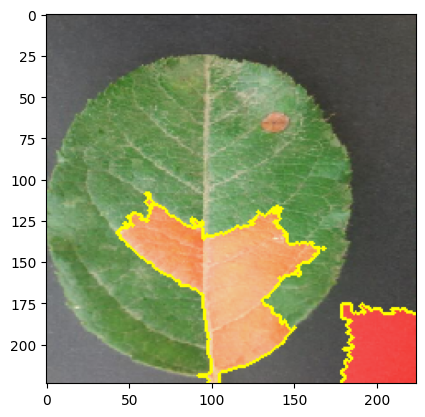

In [105]:

IMAGE = '../data/test/alternaria_leaf_spot/000424.jpg'
MODEL = patho_model_10 
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out) 


images = transform_img_fn([os.path.join(IMAGE)])
preds = MODEL.predict(images) 
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), MODEL.predict, top_labels=5, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=4, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=4, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
images = transform_img_fn([os.path.join(IMAGE)])
preds = MODEL.predict(images) 


In [106]:
# for jokes:

import lime
import tensorflow as tf
from tensorflow import keras
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path):
    """
    Load and preprocess an image from the given path.
    """
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def display_original_and_explanation(image_path, model, num_features=5, num_samples=1000):
    """
    Display the original image and its explanation generated by LIME.
    """
    # Load and preprocess the original image
    original_image = load_and_preprocess_image(image_path)
    
    # Create a LIME explainer
    explainer = lime_image.LimeImageExplainer()
    
    # Generate explanation for the model's prediction
    explanation = explainer.explain_instance(original_image[0].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=num_samples)
    
    # Get the visualized explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=num_features, hide_rest=True)
    
    # Plot the original image with explanation
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image[0] / 255.0)
    plt.title('Original Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title('Explanation')
    plt.show()




  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 117ms/step


  1%|          | 10/1000 [00:00<00:30, 32.06it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 20/1000 [00:00<00:20, 47.65it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 30/1000 [00:00<00:16, 57.20it/s]

1/1 [==============================] - 0s 59ms/step


  4%|▍         | 40/1000 [00:00<00:17, 56.04it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 50/1000 [00:00<00:15, 61.87it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 60/1000 [00:01<00:13, 67.26it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 70/1000 [00:01<00:13, 70.79it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 80/1000 [00:01<00:12, 72.42it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 90/1000 [00:01<00:12, 74.18it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 100/1000 [00:01<00:11, 76.67it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 110/1000 [00:01<00:11, 76.96it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 120/1000 [00:01<00:11, 78.72it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 130/1000 [00:01<00:11, 77.50it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 140/1000 [00:02<00:11, 76.88it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 150/1000 [00:02<00:11, 76.24it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 160/1000 [00:02<00:10, 76.78it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 170/1000 [00:02<00:10, 78.13it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 180/1000 [00:02<00:10, 79.25it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 190/1000 [00:02<00:10, 79.97it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 200/1000 [00:02<00:10, 79.29it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 210/1000 [00:02<00:10, 78.50it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 220/1000 [00:03<00:09, 78.87it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 230/1000 [00:03<00:10, 76.07it/s]

1/1 [==============================] - 0s 82ms/step


 24%|██▍       | 240/1000 [00:03<00:12, 62.02it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 250/1000 [00:03<00:11, 66.43it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 260/1000 [00:03<00:10, 69.31it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 270/1000 [00:03<00:10, 71.47it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 280/1000 [00:03<00:09, 72.26it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 290/1000 [00:04<00:09, 73.88it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 300/1000 [00:04<00:09, 75.48it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 310/1000 [00:04<00:08, 77.27it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 320/1000 [00:04<00:08, 76.53it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 330/1000 [00:04<00:08, 76.95it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 340/1000 [00:04<00:08, 77.52it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 350/1000 [00:04<00:08, 78.15it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 360/1000 [00:04<00:08, 77.68it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 370/1000 [00:05<00:08, 78.30it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 380/1000 [00:05<00:07, 78.53it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 390/1000 [00:05<00:07, 79.13it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 400/1000 [00:05<00:07, 79.18it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 410/1000 [00:05<00:07, 80.37it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 420/1000 [00:05<00:07, 81.29it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 430/1000 [00:05<00:07, 80.03it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 440/1000 [00:06<00:08, 69.62it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 450/1000 [00:06<00:07, 72.68it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 460/1000 [00:06<00:07, 75.08it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 470/1000 [00:06<00:06, 77.36it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 480/1000 [00:06<00:06, 79.00it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 490/1000 [00:06<00:06, 78.02it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 500/1000 [00:06<00:06, 79.72it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 510/1000 [00:06<00:06, 80.37it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 520/1000 [00:07<00:05, 80.38it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 530/1000 [00:07<00:05, 79.15it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 540/1000 [00:07<00:05, 79.21it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 550/1000 [00:07<00:05, 78.71it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 560/1000 [00:07<00:05, 78.76it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 570/1000 [00:07<00:05, 78.28it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 580/1000 [00:07<00:05, 78.97it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 590/1000 [00:07<00:05, 78.88it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 600/1000 [00:08<00:05, 79.29it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 610/1000 [00:08<00:04, 78.44it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 620/1000 [00:08<00:04, 78.75it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 630/1000 [00:08<00:04, 79.24it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▍   | 640/1000 [00:08<00:05, 65.66it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 650/1000 [00:08<00:05, 69.04it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 660/1000 [00:08<00:04, 71.32it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 670/1000 [00:09<00:04, 74.34it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 680/1000 [00:09<00:04, 76.20it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 690/1000 [00:09<00:04, 77.43it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 700/1000 [00:09<00:03, 77.43it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 710/1000 [00:09<00:03, 77.84it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 720/1000 [00:09<00:03, 78.60it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 730/1000 [00:09<00:03, 77.61it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 740/1000 [00:09<00:03, 78.06it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 750/1000 [00:10<00:03, 78.97it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 760/1000 [00:10<00:03, 78.09it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 770/1000 [00:10<00:02, 78.95it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 780/1000 [00:10<00:02, 79.48it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 790/1000 [00:10<00:02, 74.80it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 800/1000 [00:10<00:02, 77.10it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 810/1000 [00:10<00:02, 78.85it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 820/1000 [00:10<00:02, 79.54it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 830/1000 [00:11<00:02, 73.25it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 840/1000 [00:11<00:02, 75.64it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 850/1000 [00:11<00:01, 76.91it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 860/1000 [00:11<00:01, 78.41it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 870/1000 [00:11<00:01, 78.67it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 880/1000 [00:11<00:01, 79.57it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 890/1000 [00:11<00:01, 79.39it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 900/1000 [00:11<00:01, 80.10it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 910/1000 [00:12<00:01, 80.16it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 920/1000 [00:12<00:00, 81.01it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 930/1000 [00:12<00:00, 81.51it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 940/1000 [00:12<00:00, 81.18it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 950/1000 [00:12<00:00, 81.12it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 960/1000 [00:12<00:00, 81.55it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 970/1000 [00:12<00:00, 79.96it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 980/1000 [00:12<00:00, 80.46it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 990/1000 [00:13<00:00, 80.06it/s]

1/1 [==============================] - 0s 40ms/step


100%|██████████| 1000/1000 [00:13<00:00, 75.80it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


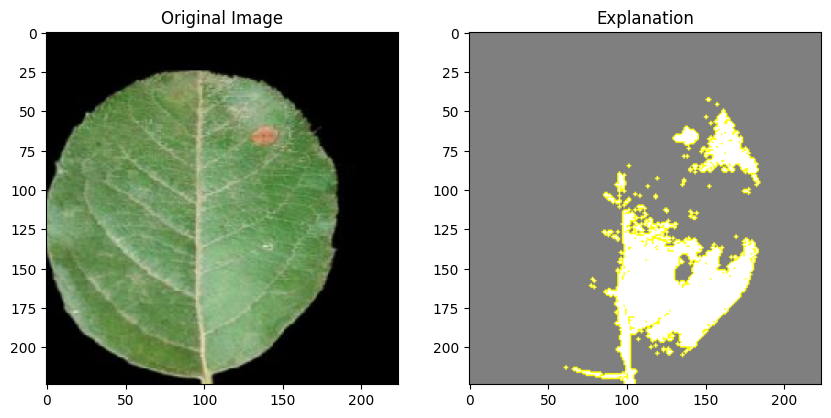

In [107]:
# Path to image file
image_path = '../data/filtered_diseases/test_filtered/alternaria_leaf_spot/000424.out.jpg'

# Assuming `patho_model_6` is your TensorFlow/Keras model
display_original_and_explanation(image_path, patho_model_10)

In [110]:
import os

directory_path = '../data/filtered_diseases/test_filtered/'

diseases = [f.name for f in os.scandir(directory_path) if f.is_dir()]

diseases

['late_blight',
 'leaf_curl',
 'powdery_mildew',
 'healthy',
 'brown_streak_disease',
 'early_blight',
 'target_spot',
 'spider_mites',
 'northern_leaf_blight',
 'isariopsis_leaf_spot',
 'red_rot',
 'leaf_mold',
 'brown_spot',
 'mosaic_disease',
 'citrus_greening',
 'bacterial_wilt',
 'bacterial_spot',
 'gray_leaf_spot',
 'black_measles',
 'blast',
 'alternaria_leaf_spot',
 'bacterial_blight',
 'black_rot',
 'tungro',
 'common_rust']

In [113]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

class_names = diseases

def display_class_probabilities(model, img_path, class_names):
    # Load and preprocess the input data
    img = image.load_img(img_path, target_size=(224, 224)) 
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get class probabilities
    probabilities = model.predict(img_array)[0]

    # Display class probabilities with class names
    for class_name, prob in zip(class_names, probabilities):
        print(f"{class_name}: {prob}")


In [114]:

display_class_probabilities(patho_model_10, image_path, class_names)

1/1 [==============================] - 1s 742ms/step
late_blight: 0.8795059323310852
leaf_curl: 0.0002674701972864568
powdery_mildew: 0.0005161191802471876
healthy: 0.0001961661473615095
brown_streak_disease: 0.004645857028663158
early_blight: 0.09378433972597122
target_spot: 0.0005852890899404883
spider_mites: 0.0002313550066901371
northern_leaf_blight: 0.000727026432286948
isariopsis_leaf_spot: 0.0005006653373129666
red_rot: 0.0021756228525191545
leaf_mold: 0.0010429046815261245
brown_spot: 0.0013077923795208335
mosaic_disease: 0.007285020314157009
citrus_greening: 0.0007337467395700514
bacterial_wilt: 9.842672443483025e-05
bacterial_spot: 8.1145808508154e-05
gray_leaf_spot: 6.733893678756431e-05
black_measles: 5.253722338238731e-05
blast: 0.0005131782381795347
alternaria_leaf_spot: 0.0041543664410710335
bacterial_blight: 0.000648557033855468
black_rot: 0.00014914755593053997
tungro: 7.140239176806062e-05
common_rust: 0.0006585422670468688


In [115]:
epochs = 6

hist_test = model.fit(train_ds, epochs=epochs, validation_data=val_ds)



Epoch 1/6
1725/1725 [==============================] - 498s 283ms/step - loss: 1.0535 - accuracy: 0.7453 - val_loss: 0.6193 - val_accuracy: 0.8003
Epoch 2/6
1725/1725 [==============================] - 495s 287ms/step - loss: 0.7442 - accuracy: 0.7738 - val_loss: 0.6819 - val_accuracy: 0.7954
Epoch 3/6
1725/1725 [==============================] - 445s 258ms/step - loss: 0.7648 - accuracy: 0.7720 - val_loss: 0.6783 - val_accuracy: 0.7872
Epoch 4/6
1725/1725 [==============================] - 446s 259ms/step - loss: 0.7875 - accuracy: 0.7689 - val_loss: 0.6560 - val_accuracy: 0.8017
Epoch 5/6
1725/1725 [==============================] - 561s 325ms/step - loss: 0.7917 - accuracy: 0.7695 - val_loss: 0.7309 - val_accuracy: 0.7934
Epoch 6/6
1725/1725 [==============================] - 30657s 18s/step - loss: 0.7956 - accuracy: 0.7708 - val_loss: 0.6433 - val_accuracy: 0.8090


In [122]:
dataset_test_path = '../data/external_test_data/'

#subfolders = [f.name for f in os.scandir(dataset_test_path) if f.is_dir() and f.name != '_untrained_classes']

test_ds = load_test(dataset_test_path)

Found 55 files belonging to 25 classes.


In [123]:

# Step 1: Get the true labels from the test dataset
y_true = []
for filepath in test_ds.file_paths:
    label = os.path.basename(os.path.dirname(filepath))
    y_true.append(label)

# Extract unique class labels from your training data
classes = sorted(set(y_true))

# Step 2: Convert true labels to indices using the same mapping used during training
class_to_index = {cls: i for i, cls in enumerate(classes)}
y_true_indices = np.array([class_to_index[label] for label in y_true])

# Step 3: Use your model to make predictions on the test dataset
y_pred_probabilities = patho_model_10.predict(test_ds)

# Step 4: Convert the predicted class probabilities to class labels
y_pred_indices = np.argmax(y_pred_probabilities, axis=1)
y_pred = [classes[i] for i in y_pred_indices]

# Step 5: Generate the classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

2024-02-23 10:20:04.590355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 5s 3s/step
Classification Report:
                      precision    recall  f1-score   support

alternaria_leaf_spot       0.00      0.00      0.00         2
    bacterial_blight       0.00      0.00      0.00         3
      bacterial_spot       0.67      0.67      0.67         3
      bacterial_wilt       1.00      1.00      1.00         2
       black_measles       0.00      0.00      0.00         2
           black_rot       0.25      1.00      0.40         2
               blast       0.50      0.50      0.50         2
          brown_spot       0.00      0.00      0.00         1
brown_streak_disease       0.50      0.50      0.50         2
     citrus_greening       0.00      0.00      0.00         2
         common_rust       1.00      0.50      0.67         2
        early_blight       0.00      0.00      0.00         2
      gray_leaf_spot       0.50      0.50      0.50         2
             healthy       0.50      0.71      0.59       

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [126]:
import os
import cv2
import numpy as np
from sklearn.metrics import classification_report
from rembg import remove

def remove_background_and_predict(model, test_dataset):
    # Step 1: Get the true labels from the test dataset
    y_true = []
    for filepath in test_dataset.file_paths:
        label = os.path.basename(os.path.dirname(filepath))
        y_true.append(label)
    
    # Extract unique class labels from your training data
    classes = sorted(set(y_true))
    
    # Step 2: Convert true labels to indices using the same mapping used during training
    class_to_index = {cls: i for i, cls in enumerate(classes)}
    y_true_indices = np.array([class_to_index[label] for label in y_true])
    
    # Step 3: Use your model to make predictions on the test dataset after removing backgrounds
    y_pred_probabilities = []
    for filepath in test_dataset.file_paths:
        # Load image
        image = cv2.imread(filepath)
        # Remove background using rembg
        image_no_bg = remove(image)
        # Resize image to match model input size (if needed)
        # image_no_bg_resized = cv2.resize(image_no_bg, desired_size)
        # Make prediction
        prediction = model.predict(image_no_bg)  # Adjust input if necessary
        y_pred_probabilities.append(prediction)
    
    y_pred_probabilities = np.array(y_pred_probabilities)
    
    # Step 4: Convert the predicted class probabilities to class labels
    y_pred_indices = np.argmax(y_pred_probabilities, axis=1)
    y_pred = [classes[i] for i in y_pred_indices]
    
    # Step 5: Generate the classification report
    report = classification_report(y_true, y_pred)
    print("Classification Report:")
    print(report)

# Usage example:
# remove_background_and_predict(patho_model_10, test_ds)


In [127]:
remove_background_and_predict(patho_model_10, test_ds)


2024-02-23 11:05:37.040177 [W:onnxruntime:, coreml_execution_provider.cc:81 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 67 number of nodes in the graph: 371 number of nodes supported by CoreML: 300


ValueError: in user code:

    File "/Users/freyasteinhagen/neue_fische/AgronomiCare/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/Users/freyasteinhagen/neue_fische/AgronomiCare/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/freyasteinhagen/neue_fische/AgronomiCare/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/freyasteinhagen/neue_fische/AgronomiCare/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/Users/freyasteinhagen/neue_fische/AgronomiCare/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/freyasteinhagen/neue_fische/AgronomiCare/.venv/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "EfficientNet" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 1280, 4)
